# Tech Challenge

## Dados "crus"

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
dados_exportacao = pd.read_csv("http://vitibrasil.cnpuv.embrapa.br/download/ExpVinho.csv", sep=";")
dados_exportacao.set_index("Id", inplace=True)
dados_exportacao.head()

,País,1970,1970.1,1971,1971.1,1972,1972.1,1973,1973.1,1974,...,2018,2018.1,2019,2019.1,2020,2020.1,2021,2021.1,2022,2022.1
Id,,,,,,,,,,,,,,,,,,,,,
1,Afeganistão,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,46,0,0
2,África do Sul,0,0,0,0,0,0,0,0,0,...,0,0,26,95,4,21,0,0,0,0
3,"Alemanha, República Democrática",0,0,0,0,4168,2630,12000,8250,0,...,10794,45382,3660,25467,6261,32605,2698,6741,7630,45367
4,Angola,0,0,0,0,0,0,0,0,0,...,477,709,345,1065,0,0,0,0,4068,4761
5,Anguilla,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Limpeza dos dados

In [3]:
dados_exportacao = dados_exportacao.melt(
    id_vars=["País"], value_vars=[col for col in dados_exportacao.columns if col not in ("Id", "País")], var_name="Ano_Tipo", value_name="Valor"
)

dados_exportacao["Ano"] = dados_exportacao["Ano_Tipo"].str.extract(r"(\d+)", expand=False)
dados_exportacao["Tipo"] = dados_exportacao["Ano_Tipo"].apply(lambda x: "Quantidade (L)" if ".1" not in x else "Valor (US$)")
dados_exportacao.drop(columns="Ano_Tipo", inplace=True)
dados_exportacao["Origem"] = "Brasil"

In [4]:
dados_exportacao.sample(5)

,País,Valor,Ano,Tipo,Origem
8805,Portugal,16080,2004,Quantidade (L),Brasil
2418,Suriname,0,1979,Quantidade (L),Brasil
7251,"Marshall, Ilhas",0,1998,Quantidade (L),Brasil
3011,Ilhas Virgens,0,1981,Valor (US$),Brasil
9385,Dinamarca,8417,2006,Valor (US$),Brasil


In [5]:
dados_quantidade = dados_exportacao.query("Tipo == 'Quantidade (L)'")
dados_quantidade = dados_quantidade.drop("Tipo", axis=1)
dados_quantidade = dados_quantidade.rename(columns={"Valor": "Quantidade (L)"})
dados_quantidade.head()

,País,Quantidade (L),Ano,Origem
0,Afeganistão,0,1970,Brasil
1,África do Sul,0,1970,Brasil
2,"Alemanha, República Democrática",0,1970,Brasil
3,Angola,0,1970,Brasil
4,Anguilla,0,1970,Brasil


In [6]:
dados_preco = dados_exportacao.query("Tipo == 'Valor (US$)'")
dados_preco = dados_preco.drop("Tipo", axis=1)
dados_preco = dados_preco.rename(columns={"Valor": "Valor (US$)"})
dados_preco.head()

,País,Valor (US$),Ano,Origem
128,Afeganistão,0,1970,Brasil
129,África do Sul,0,1970,Brasil
130,"Alemanha, República Democrática",0,1970,Brasil
131,Angola,0,1970,Brasil
132,Anguilla,0,1970,Brasil


In [7]:
dados_exportacao = dados_quantidade.merge(dados_preco)

# Removendo dados anteriores há 15 anos
dados_exportacao = dados_exportacao.drop(dados_exportacao[dados_exportacao.Ano.astype("int") < 2007].index)

## Tabela de exportação

In [8]:
dados_exportacao.head()

,País,Quantidade (L),Ano,Origem,Valor (US$)
4736,Afeganistão,0,2007,Brasil,0
4737,África do Sul,0,2007,Brasil,0
4738,"Alemanha, República Democrática",119512,2007,Brasil,238052
4739,Angola,25931,2007,Brasil,49753
4740,Anguilla,0,2007,Brasil,0


## Quantidade (L) e Valor (US$) ao longo dos anos

É possível notar uma queda nas vendas após 2014, porém também é possível observar uma tendência de crescimento logo após.

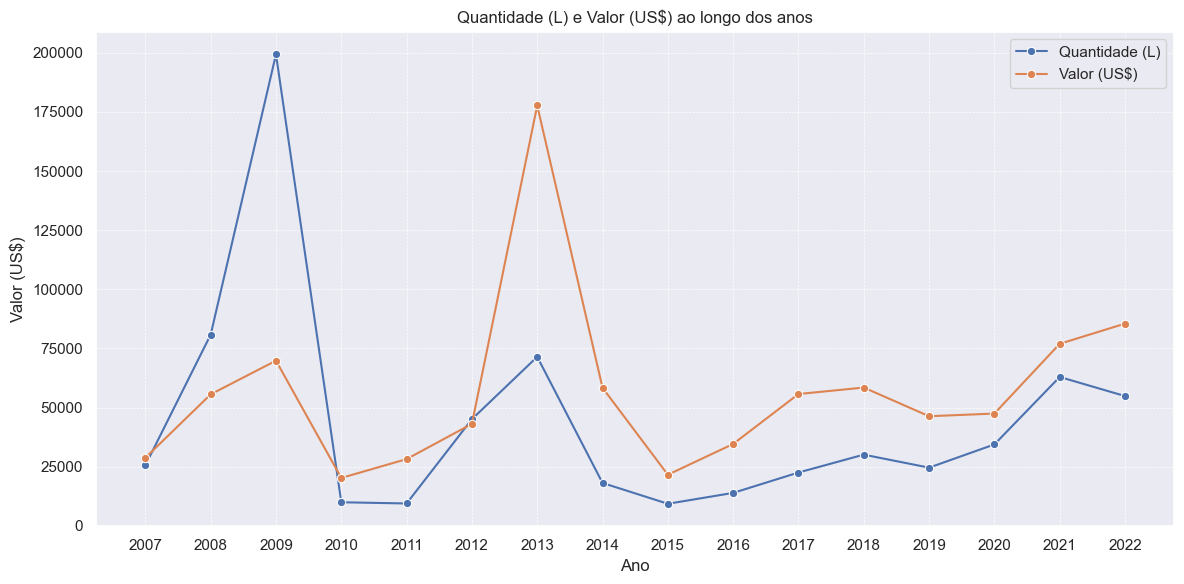

In [9]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=dados_exportacao, x="Ano", y="Quantidade (L)", marker="o", errorbar=None)
sns.lineplot(data=dados_exportacao, x="Ano", y="Valor (US$)", marker="o", errorbar=None, ax=ax)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.title("Quantidade (L) e Valor (US$) ao longo dos anos")
ax.legend(["Quantidade (L)", "Valor (US$)"])
plt.ylabel("Valor (US$)")
plt.tight_layout()
plt.show()

## Top 10 países com maior Valor (US$) em vendas acumuladas nos últimos 15 anos

Vemos também a importância de manter um relacionamento a longo prazo com os países que mais importam vinhos do Brasil. Um destes que é notavel é o Paraguai, onde as vendas são aproximadamente 30% superiores ao segundo colocado, a Rússia.

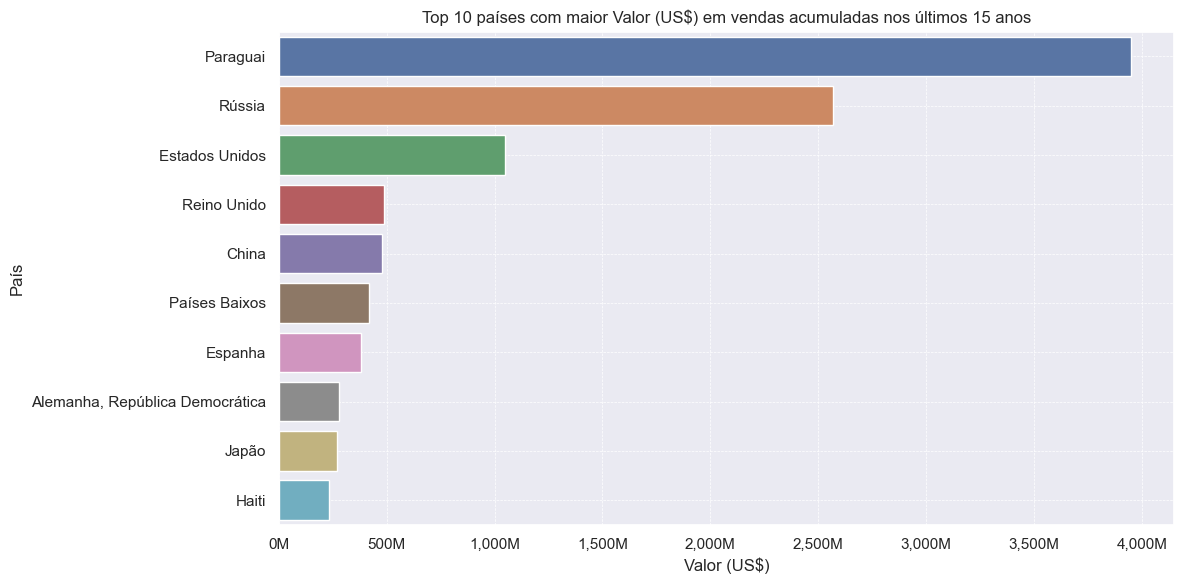

In [10]:
top_10_paises = dados_exportacao.groupby(["País"]).sum(["Valor (US$)"]).sort_values(by=["Valor (US$)"], ascending=False).head(10)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Valor (US$)", y="País", hue="País", data=top_10_paises)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10000) + 'M'))

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Top 10 países com maior Valor (US$) em vendas acumuladas nos últimos 15 anos")
plt.tight_layout()
plt.show()

## Top 20 países com menor Valor (US$) em vendas acumuladas nos últimos 15 anos

Existem muitos países onde o valor de exportação é muito baixo. Talvez faça sentido não dispor mais recursos para exportar para esses países. Talvez até usar um distribuidor intermediário próximo a essas localidades, isso potencialmente reduziria custos de exportação.

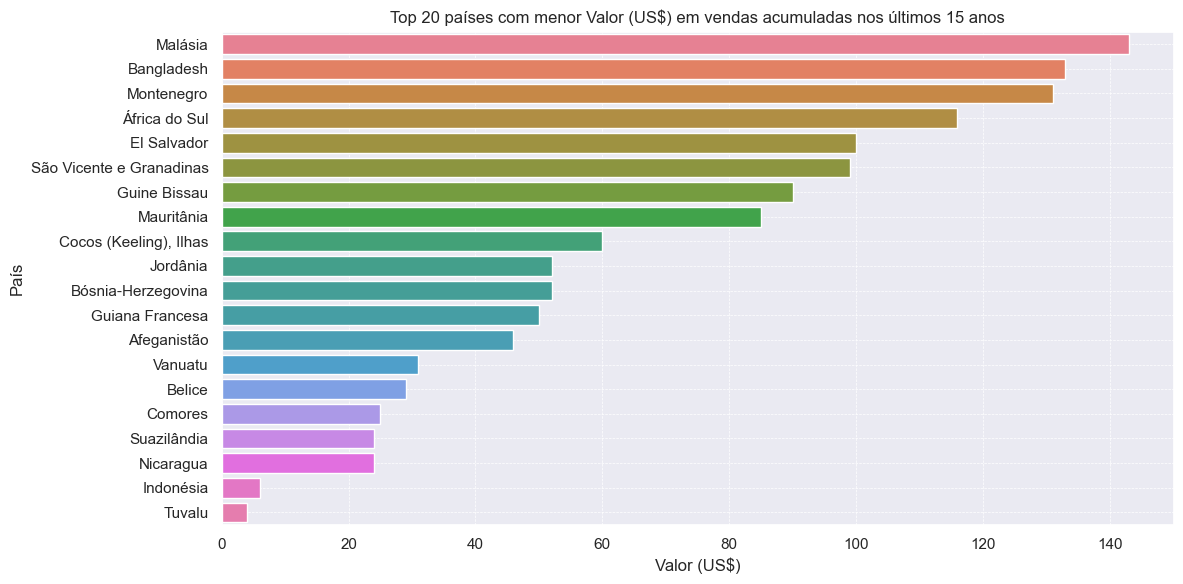

In [11]:
low_10_paises = dados_exportacao.groupby(["País"]).sum(["Valor (US$)"]).sort_values(by=["Valor (US$)"])
low_10_paises = low_10_paises[low_10_paises["Valor (US$)"] > 0].head(20).sort_values(by=["Valor (US$)"], ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Valor (US$)", y="País", hue="País", data=low_10_paises)

plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title("Top 20 países com menor Valor (US$) em vendas acumuladas nos últimos 15 anos")
plt.tight_layout()
plt.show()

## Projeção de vendas para os próximos 5 anos

Usando um modelo de regressão linear é possível observar uma tendência de queda nas vendas nos próximos anos. É importante avaliar as razões desta potencial queda, para que as devidas medidas sejam tomadas.

Mean Squared Error: 382404645145.0281


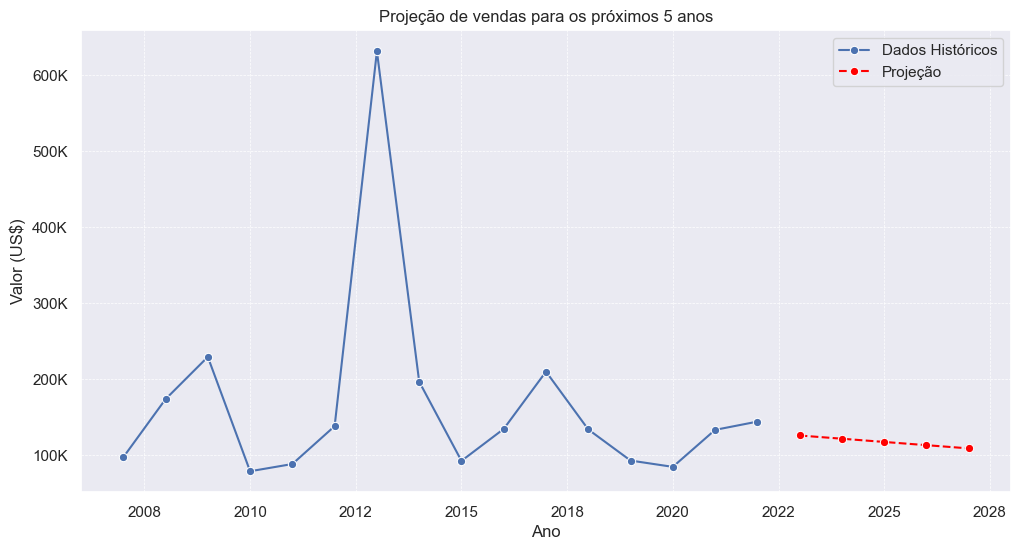

In [12]:
dados_projecao = dados_exportacao[dados_exportacao["Valor (US$)"] > 0].copy()

dados_projecao["Ano"] = dados_projecao["Ano"].astype(int)

X = dados_projecao["Ano"].values.reshape(-1, 1)
y = dados_projecao["Valor (US$)"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

future_years = np.array(range(dados_projecao["Ano"].max()+1, dados_projecao["Ano"].max()+6)).reshape(-1, 1)
future_sales = model.predict(future_years)

plt.figure(figsize=(12, 6))

ax = sns.lineplot(x=dados_projecao["Ano"], y=dados_projecao["Valor (US$)"], label="Dados Históricos", marker="o", errorbar=None)
sns.lineplot(x=future_years.squeeze(), y=future_sales, label="Projeção", linestyle="--", marker="o", color="red", ax=ax)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))

plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.xlabel("Ano")
plt.ylabel("Valor (US$)")
plt.title("Projeção de vendas para os próximos 5 anos")
plt.legend()

plt.show()